In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

In [2]:

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

# Creating the model

In [4]:
numeric_variables = ['overallqual','firstflrsf','totrmsabvgrd']
variables = numeric_variables + ['neighborhood','exterior1st','saleprice']

In [5]:
df2 = pd.get_dummies(df[variables])
X = df2.drop('saleprice', axis=1)
y = df2.saleprice



In [6]:
lrm = linear_model.LinearRegression().fit(X,y)
predictions = lrm.predict(X)
errors = y-predictions

# Checking for assumptions

## Homoscedasticity

In [7]:
bartlett_stats = stats.bartlett(predictions,errors)
levene_stats = stats.levene(predictions,errors)
print('Bartlett p value: ',bartlett_stats[1])
print('Levene p value: ', levene_stats[1])

Bartlett p value:  1.5346486715104397e-128
Levene p value:  5.430518383486349e-95


From the p values, we can reject the null hypothesis that the model is homoscedastic.  It is likely I am excluding some important variables.  OLS can still be used for predictions but any hypothesis testing on parameters will be biased.

## (No perfect) multicolinearity

In [8]:
for i in range(X.shape[1]):
    print('VIF for ',X.columns[i],': ', variance_inflation_factor(X.values, i))

VIF for  overallqual :  2.6414479101325044
VIF for  firstflrsf :  1.8107072292866675
VIF for  totrmsabvgrd :  1.4710602538507669
VIF for  neighborhood_Blmngtn :  inf
VIF for  neighborhood_Blueste :  inf
VIF for  neighborhood_BrDale :  inf
VIF for  neighborhood_BrkSide :  inf
VIF for  neighborhood_ClearCr :  inf
VIF for  neighborhood_CollgCr :  inf
VIF for  neighborhood_Crawfor :  inf
VIF for  neighborhood_Edwards :  inf
VIF for  neighborhood_Gilbert :  inf
VIF for  neighborhood_IDOTRR :  inf
VIF for  neighborhood_MeadowV :  inf
VIF for  neighborhood_Mitchel :  inf
VIF for  neighborhood_NAmes :  inf
VIF for  neighborhood_NPkVill :  inf
VIF for  neighborhood_NWAmes :  inf
VIF for  neighborhood_NoRidge :  inf
VIF for  neighborhood_NridgHt :  inf
VIF for  neighborhood_OldTown :  inf
VIF for  neighborhood_SWISU :  inf
VIF for  neighborhood_Sawyer :  inf
VIF for  neighborhood_SawyerW :  inf
VIF for  neighborhood_Somerst :  inf
VIF for  neighborhood_StoneBr :  inf
VIF for  neighborhood_Timber

All my one hot encoded variables are colinear as I did not know to exclude the first subcategory.  I am lucky OLS converged.  However any hypothesis testing on factors will be unreliable.

## Uncorrelated error terms

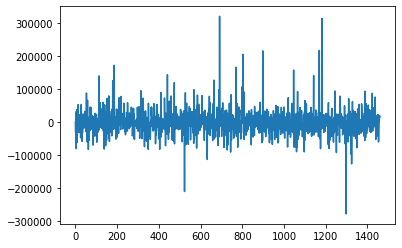

In [9]:
plt.plot(errors)

There does appear to be randomness, therefore error terms are most likely uncorrelated.

## Normality of errors

(array([  1.,   0.,   1.,   0.,   0.,   0.,   2.,   5.,  34.,  97., 266.,
        545., 353.,  98.,  27.,  15.,   5.,   3.,   3.,   0.,   3.,   0.,
          0.,   0.,   2.]),
 array([-278787.29298127, -254804.16248614, -230821.03199102,
        -206837.9014959 , -182854.77100078, -158871.64050565,
        -134888.51001053, -110905.37951541,  -86922.24902028,
         -62939.11852516,  -38955.98803004,  -14972.85753491,
           9010.27296021,   32993.40345533,   56976.53395045,
          80959.66444558,  104942.7949407 ,  128925.92543582,
         152909.05593095,  176892.18642607,  200875.31692119,
         224858.44741632,  248841.57791144,  272824.70840656,
         296807.83890169,  320790.96939681]),
 <BarContainer object of 25 artists>)

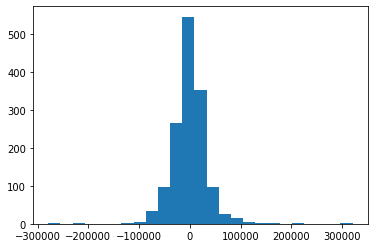

In [11]:
plt.hist(errors, bins = 25)

In [12]:
stats.describe(errors)

DescribeResult(nobs=1460, minmax=(-278787.29298126785, 320790.9693968084), mean=5.3503206127310456e-11, variance=1345749319.3316987, skewness=1.1792318696614896, kurtosis=13.609780875322116)

The histogram appears normal.  However the kurtosis value is large, meaning the errors are not normal. Statistical significance of coefficients can not accurately be measured.